In [9]:
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras.preprocessing.image as image
import numpy as np
import matplotlib.pyplot as plt

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16
input_shape = (img_width, img_height, 3) # 3 Channel, di belakang karena menggunakan tensorflow's channel_last


# path to the model weights files.
# weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = 'fc_model.h5'

In [33]:
# prepare data augmentation configuration
train_datagen = image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


In [11]:
# build the VGG16 network
base_model = applications.VGG16(weights='imagenet',include_top= False, input_shape=(150, 150, 3))
print('Model loaded.')

Model loaded.


In [25]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # Net =  VGG.input -> VGG.output -> top_model -> output

In [26]:
i = 0
for layer in base_model.layers:
    print(i,layer,layer.trainable)
    i+=1

(0, <keras.engine.topology.InputLayer object at 0x7fbf315e78d0>, False)
(1, <keras.layers.convolutional.Conv2D object at 0x7fbf315e7a50>, False)
(2, <keras.layers.convolutional.Conv2D object at 0x7fbf315ac050>, False)
(3, <keras.layers.pooling.MaxPooling2D object at 0x7fbf315ac210>, False)
(4, <keras.layers.convolutional.Conv2D object at 0x7fbf315acd10>, False)
(5, <keras.layers.convolutional.Conv2D object at 0x7fbf314945d0>, False)
(6, <keras.layers.pooling.MaxPooling2D object at 0x7fbf314b4510>, False)
(7, <keras.layers.convolutional.Conv2D object at 0x7fbf314ec910>, False)
(8, <keras.layers.convolutional.Conv2D object at 0x7fbf314f4710>, False)
(9, <keras.layers.convolutional.Conv2D object at 0x7fbf9c5b4850>, False)
(10, <keras.layers.pooling.MaxPooling2D object at 0x7fbf3150f5d0>, False)
(11, <keras.layers.convolutional.Conv2D object at 0x7fbf31525bd0>, False)
(12, <keras.layers.convolutional.Conv2D object at 0x7fbf31af9910>, False)
(13, <keras.layers.convolutional.Conv2D object at

In [27]:
# Layer top_model yang menggantikan top layer VGG yang asli
i = 0
for layer in top_model.layers:
    print(i,layer,layer.trainable)
    i+=1

(0, <keras.layers.core.Flatten object at 0x7fbf31387490>, True)
(1, <keras.layers.core.Dense object at 0x7fbf3135ca50>, True)
(2, <keras.layers.core.Dropout object at 0x7fbf31286490>, True)
(3, <keras.layers.core.Dense object at 0x7fbf31286f10>, True)


In [30]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
i = 0
for layer in model.layers[:19]: # Tutorial nulis 25, kita coba ubah 15 atau 19
    layer.trainable = False
    print(i,layer,layer.trainable)
    i+=1
print(i,model.layers[19],model.layers[19].trainable)

(0, <keras.engine.topology.InputLayer object at 0x7fbf315e78d0>, False)
(1, <keras.layers.convolutional.Conv2D object at 0x7fbf315e7a50>, False)
(2, <keras.layers.convolutional.Conv2D object at 0x7fbf315ac050>, False)
(3, <keras.layers.pooling.MaxPooling2D object at 0x7fbf315ac210>, False)
(4, <keras.layers.convolutional.Conv2D object at 0x7fbf315acd10>, False)
(5, <keras.layers.convolutional.Conv2D object at 0x7fbf314945d0>, False)
(6, <keras.layers.pooling.MaxPooling2D object at 0x7fbf314b4510>, False)
(7, <keras.layers.convolutional.Conv2D object at 0x7fbf314ec910>, False)
(8, <keras.layers.convolutional.Conv2D object at 0x7fbf314f4710>, False)
(9, <keras.layers.convolutional.Conv2D object at 0x7fbf9c5b4850>, False)
(10, <keras.layers.pooling.MaxPooling2D object at 0x7fbf3150f5d0>, False)
(11, <keras.layers.convolutional.Conv2D object at 0x7fbf31525bd0>, False)
(12, <keras.layers.convolutional.Conv2D object at 0x7fbf31af9910>, False)
(13, <keras.layers.convolutional.Conv2D object at

In [31]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [34]:
# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 9s - loss: 0.5934 - acc: 0.9220 - val_loss: 0.9901 - val_acc: 0.9000
Epoch 2/50
125/125 [==============================] - 9s - loss: 0.6635 - acc: 0.9275 - val_loss: 0.8876 - val_acc: 0.9046
Epoch 3/50
125/125 [==============================] - 8s - loss: 0.5067 - acc: 0.9255 - val_loss: 1.0686 - val_acc: 0.8740
Epoch 4/50
125/125 [==============================] - 8s - loss: 0.4341 - acc: 0.9345 - val_loss: 0.8840 - val_acc: 0.9020
Epoch 5/50
125/125 [==============================] - 8s - loss: 0.4541 - acc: 0.9255 - val_loss: 0.6909 - val_acc: 0.8957
Epoch 6/50
125/125 [==============================] - 8s - loss: 0.4212 - acc: 0.9265 - val_loss: 0.7511 - val_acc: 0.9008
Epoch 7/50
125/125 [==============================] - 8s - loss: 0.4216 - acc: 0.9270 - val_loss: 0.6757 - val_acc: 0.8995
Epoch 8/50
125/125 [==============================] - 8s - loss: 0.3545 - acc: 0.9305 - val_loss: 0.6596 - val_acc: 0.8893
Epoch 9/50
125/1

data/validation/dogs/dog.1109.jpg


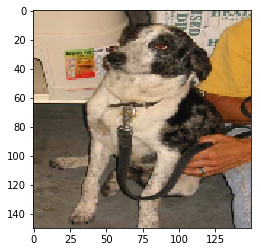

Predict: Dog, Actual: Dog
data/validation/dogs/dog.1159.jpg


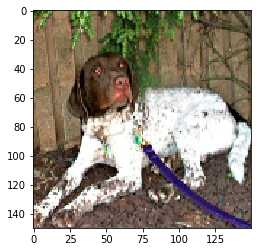

Predict: Dog, Actual: Dog
data/validation/dogs/dog.1134.jpg


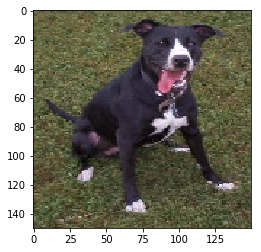

Predict: Dog, Actual: Dog
data/validation/dogs/dog.1277.jpg


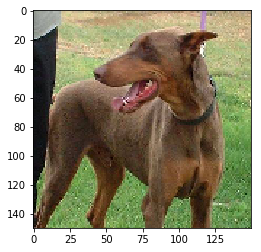

Predict: Dog, Actual: Dog
data/validation/dogs/dog.1255.jpg


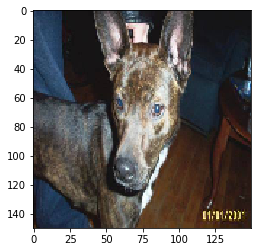

Predict: Dog, Actual: Dog
data/validation/dogs/dog.1359.jpg


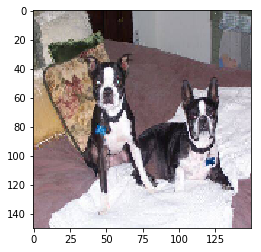

Predict: Dog, Actual: Dog
data/validation/dogs/dog.1118.jpg


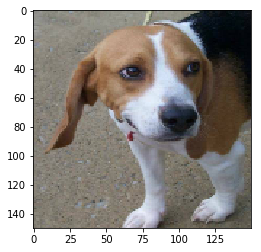

Predict: Dog, Actual: Dog
data/validation/dogs/dog.1197.jpg


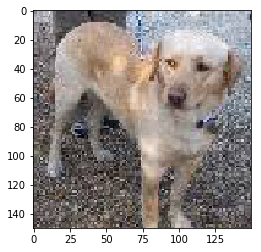

Predict: Dog, Actual: Dog
data/validation/dogs/dog.1030.jpg


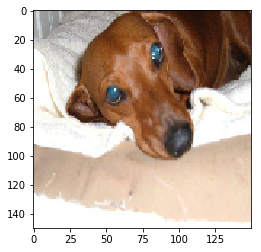

Predict: Dog, Actual: Dog


In [75]:
def check(probs,answer):
    if(probs[0,0] == 0):
        print('Predict: Cat, Actual: ' + answer)
    else:
        print('Predict: Dog, Actual: ' + answer)
        
def showtest(model):        
    for i in range(9):
        if (np.random.randint(1,2+1) == 1):
            img_path = 'data/validation/cats/cat.'
            answer = 'Cat'
        else:
            img_path = 'data/validation/dogs/dog.'
            answer = 'Dog'

        img_path += str(np.random.randint(1000,1400+1)) + '.jpg'
        print(img_path)
        img = image.load_img(img_path, target_size=(150,150))
        plt.imshow(img)
        plt.show()
        img = image.img_to_array(img)
        img = img.reshape((1,) + img.shape)
        probs = model.predict(img)
        check(probs, answer)

showtest(model)

In [70]:
# Change Trainable layers until layer 15

model2 = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# Trainable = true
for layer in model2.layers:
    layer.trainable = True

# Trainable = false for 0 - 14
for layer in model2.layers[:15]:
    layer.trainable = False

# Show All    
i = 0
for layer in model2.layers:
    print(i,layer,layer.trainable)
    i+=1

model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model2.summary()

(0, <keras.engine.topology.InputLayer object at 0x7fbf315e78d0>, False)
(1, <keras.layers.convolutional.Conv2D object at 0x7fbf315e7a50>, False)
(2, <keras.layers.convolutional.Conv2D object at 0x7fbf315ac050>, False)
(3, <keras.layers.pooling.MaxPooling2D object at 0x7fbf315ac210>, False)
(4, <keras.layers.convolutional.Conv2D object at 0x7fbf315acd10>, False)
(5, <keras.layers.convolutional.Conv2D object at 0x7fbf314945d0>, False)
(6, <keras.layers.pooling.MaxPooling2D object at 0x7fbf314b4510>, False)
(7, <keras.layers.convolutional.Conv2D object at 0x7fbf314ec910>, False)
(8, <keras.layers.convolutional.Conv2D object at 0x7fbf314f4710>, False)
(9, <keras.layers.convolutional.Conv2D object at 0x7fbf9c5b4850>, False)
(10, <keras.layers.pooling.MaxPooling2D object at 0x7fbf3150f5d0>, False)
(11, <keras.layers.convolutional.Conv2D object at 0x7fbf31525bd0>, False)
(12, <keras.layers.convolutional.Conv2D object at 0x7fbf31af9910>, False)
(13, <keras.layers.convolutional.Conv2D object at

In [71]:
# fine-tune the model
model2.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 9s - loss: 0.2553 - acc: 0.9115 - val_loss: 0.3965 - val_acc: 0.8308
Epoch 2/50
125/125 [==============================] - 8s - loss: 0.2177 - acc: 0.9200 - val_loss: 0.2909 - val_acc: 0.9224
Epoch 3/50
125/125 [==============================] - 8s - loss: 0.1328 - acc: 0.9550 - val_loss: 0.3284 - val_acc: 0.8880
Epoch 4/50
125/125 [==============================] - 8s - loss: 0.1348 - acc: 0.9510 - val_loss: 0.2695 - val_acc: 0.9173
Epoch 5/50
125/125 [==============================] - 8s - loss: 0.1033 - acc: 0.9650 - val_loss: 0.2840 - val_acc: 0.9211
Epoch 6/50
125/125 [==============================] - 8s - loss: 0.0980 - acc: 0.9655 - val_loss: 0.3068 - val_acc: 0.9326
Epoch 7/50
125/125 [==============================] - 8s - loss: 0.0873 - acc: 0.9680 - val_loss: 0.2540 - val_acc: 0.9338
Epoch 8/50
125/125 [==============================] - 8s - loss: 0.0699 - acc: 0.9740 - val_loss: 0.2916 - val_acc: 0.9198
Epoch 9/50
125/1

data/validation/cats/cat.1142.jpg


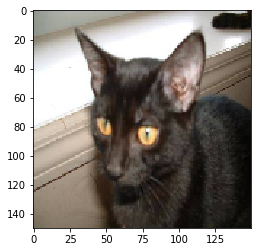

Predict: Cat, Actual: Cat
data/validation/cats/cat.1380.jpg


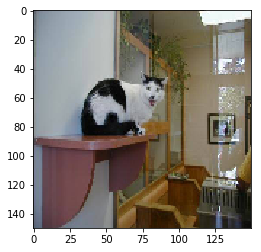

Predict: Dog, Actual: Cat
data/validation/cats/cat.1091.jpg


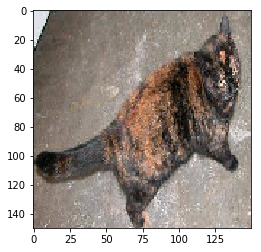

Predict: Dog, Actual: Cat
data/validation/cats/cat.1047.jpg


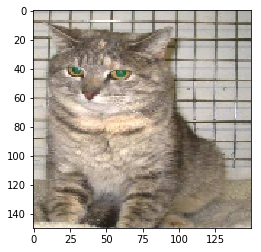

Predict: Cat, Actual: Cat
data/validation/cats/cat.1289.jpg


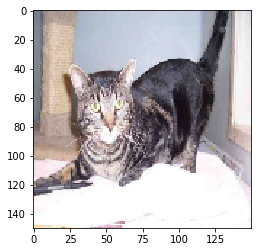

Predict: Cat, Actual: Cat
data/validation/cats/cat.1072.jpg


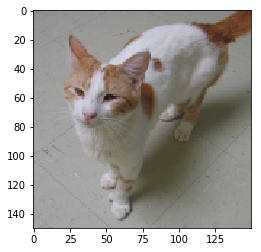

Predict: Dog, Actual: Cat
data/validation/dogs/dog.1298.jpg


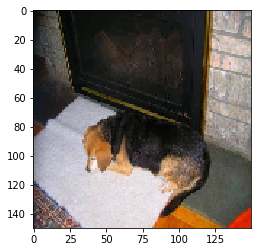

Predict: Cat, Actual: Dog
data/validation/dogs/dog.1170.jpg


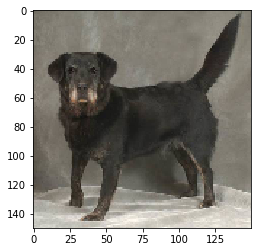

Predict: Dog, Actual: Dog
data/validation/cats/cat.1026.jpg


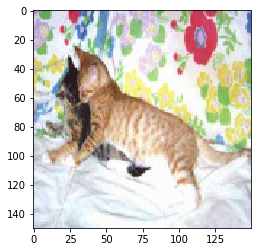

Predict: Cat, Actual: Cat


In [77]:
showtest(model2)

# acc vs val_acc?
ref: http://stackoverflow.com/questions/34702041/how-to-tell-which-keras-model-is-better

> Do I use the "acc" (from the training data?) one or the "val acc" (from the validation data?) one?

If you want to estimate the ability of your model to generalize to new data (which is probably what you want to do), then you look at the validation accuracy, because the validation split contains only data that the model never sees during the training and therefor cannot just memorize.

If your training data accuracy ("acc") keeps improving while your validation data accuracy ("val_acc") gets worse, you are likely in an overfitting situation, i.e. your model starts to basically just memorize the data.

> There are different accs and val accs for each epoch. How do I know the acc or val acc for my model as a whole? Do I average all of the epochs accs or val accs to find the acc or val acc of the model as a whole?

Each epoch is a training run over all of your data. During that run the parameters of your model are adjusted according to your loss function. The result is a set of parameters which have a certain ability to generalize to new data. That ability is reflected by the validation accuracy. So think of every epoch as its own model, which can get better or worse if it is trained for another epoch. Whether it got better or worse is judged by the change in validation accuracy (better = validation accuracy increased). Therefore pick the model of the epoch with the highest validation accuracy. Don't average the accuracies over different epochs, that wouldn't make much sense. You can use the Keras callback ModelCheckpoint to automatically save the model with the highest validation accuracy (see callbacks documentation).

The highest accuracy in model 1 is 0.7737 and the highest one in model 2 is 0.7572. Therefore you should view model 1 (at epoch 3) as better. Though it is possible that the 0.7737 was just a random outlier.

In [76]:
# fine-tune the model
model2.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
125/125 [==============================] - 9s - loss: 0.0044 - acc: 0.9985 - val_loss: 0.3788 - val_acc: 0.9389
Epoch 2/100
125/125 [==============================] - 9s - loss: 0.0075 - acc: 0.9975 - val_loss: 0.3731 - val_acc: 0.9377
Epoch 3/100
125/125 [==============================] - 8s - loss: 0.0137 - acc: 0.9960 - val_loss: 0.3026 - val_acc: 0.9338
Epoch 4/100
125/125 [==============================] - 8s - loss: 0.0033 - acc: 0.9990 - val_loss: 0.3817 - val_acc: 0.9351
Epoch 5/100
125/125 [==============================] - 8s - loss: 0.0136 - acc: 0.9975 - val_loss: 0.4543 - val_acc: 0.9173
Epoch 6/100
125/125 [==============================] - 8s - loss: 0.0087 - acc: 0.9965 - val_loss: 0.3824 - val_acc: 0.9427
Epoch 7/100
125/125 [==============================] - 8s - loss: 0.0033 - acc: 0.9990 - val_loss: 0.4555 - val_acc: 0.9338
Epoch 8/100
125/125 [==============================] - 8s - loss: 0.0057 - acc: 0.9980 - val_loss: 0.4655 - val_acc: 0.9237
Epoch 9/

125/125 [==============================] - 9s - loss: 0.0044 - acc: 0.9990 - val_loss: 0.3793 - val_acc: 0.9363
Epoch 67/100
125/125 [==============================] - 8s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.4308 - val_acc: 0.9338
Epoch 68/100
125/125 [==============================] - 8s - loss: 0.0033 - acc: 0.9995 - val_loss: 0.5228 - val_acc: 0.9186
Epoch 69/100
125/125 [==============================] - 8s - loss: 0.0011 - acc: 0.9995 - val_loss: 0.4889 - val_acc: 0.9313
Epoch 70/100
125/125 [==============================] - 9s - loss: 0.0019 - acc: 0.9995 - val_loss: 0.5293 - val_acc: 0.9160
Epoch 71/100
125/125 [==============================] - 8s - loss: 0.0028 - acc: 0.9990 - val_loss: 0.4619 - val_acc: 0.9224
Epoch 72/100
125/125 [==============================] - 9s - loss: 0.0101 - acc: 0.9985 - val_loss: 0.4444 - val_acc: 0.9350
Epoch 73/100
125/125 [==============================] - 8s - loss: 0.0023 - acc: 0.9990 - val_loss: 0.4873 - val_acc: 0.9351
Epoch 74/100


# What does "sample", "batch", "epoch" mean?

Below are some common definitions that are necessary to know and understand to correctly utilize Keras:

Sample: one element of a dataset.
Example: one image is a sample in a convolutional network
Example: one audio file is a sample for a speech recognition model
Batch: a set of N samples. The samples in a batch are processed independently, in parallel. If training, a batch results in only one update to the model.
A batch generally approximates the distribution of the input data better than a single input. The larger the batch, the better the approximation; however, it is also true that the batch will take longer to processes and will still result in only one update. For inference (evaluate/predict), it is recommended to pick a batch size that is as large as you can afford without going out of memory (since larger batches will usually result in faster evaluating/prediction).
Epoch: an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation.
When using evaluation_data or evaluation_split with the fit method of Keras models, evaluation will be run at the end of every epoch.
Within Keras, there is the ability to add callbacks specifically designed to be run at the end of an epoch. Examples of these are learning rate changes and model checkpointing (saving).